In [20]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [24]:
!unzip "/content/drive/MyDrive/fp-dataset-artifacts-main (1).zip" -d "/content/drive/MyDrive/"



Archive:  /content/drive/MyDrive/fp-dataset-artifacts-main (1).zip
e7e04aa772efddd8e4b95688d3b05a981a7e0960
   creating: /content/drive/MyDrive/fp-dataset-artifacts-main/
 extracting: /content/drive/MyDrive/fp-dataset-artifacts-main/.gitignore  
  inflating: /content/drive/MyDrive/fp-dataset-artifacts-main/README.md  
  inflating: /content/drive/MyDrive/fp-dataset-artifacts-main/helpers.py  
  inflating: /content/drive/MyDrive/fp-dataset-artifacts-main/requirements.txt  
  inflating: /content/drive/MyDrive/fp-dataset-artifacts-main/run.py  


In [26]:
%cd "/content/drive/MyDrive/fp-dataset-artifacts-main"



/content/drive/MyDrive/fp-dataset-artifacts-main


In [28]:
!pip install accelerate datasets torch tqdm evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00


In [29]:
!python3 run.py --do_train --task nli --dataset snli --output_dir ./trained_model/


2025-11-28 17:05:43.084899: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-28 17:05:43.102485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764349543.123609   10442 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764349543.130072   10442 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764349543.146277   10442 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [30]:
!python3 run.py --do_eval --task nli --dataset snli --model ./trained_model/ --output_dir ./eval_output/

2025-11-28 19:44:06.419126: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-28 19:44:06.436844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764359046.458240   50736 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764359046.464936   50736 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764359046.481463   50736 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [36]:

!pip install transformers datasets scikit-learn seaborn -q



In [37]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [38]:
snli = load_dataset("snli")
test_set = snli['test']

In [58]:
import re
negation_words = [
    # Adverbs/particles
    "not", "never", "no", "none", "nothing",

    # Negative auxiliary verbs (full forms)
    "is not", "are not", "was not", "were not",
    "does not", "do not", "did not",
    "has not", "have not", "had not",
    "cannot", "will not", "would not",
    "should not", "could not",

    # Negative auxiliary verbs (contractions)
    "isn't", "aren't", "wasn't", "weren't",
    "doesn't", "don't", "didn't",
    "hasn't", "haven't", "hadn't",
    "can't", "won't", "wouldn't", "shouldn't", "couldn't",

    # Negative pronouns
    "nobody", "no one", "neither", "nowhere", "none of"
]


In [87]:
import re

def has_negation(hypothesis):
    hyp = hypothesis.lower()
    # check each negation word as a whole word
    for neg in negation_words:
        # \b ensures it matches only as a whole word
        if re.search(rf'\b{re.escape(neg)}\b', hyp):
            return True
    return False



In [88]:
negated_subset = test_set.filter(lambda x: has_negation(x['hypothesis']))
print(f"Total naturally negated hypotheses: {len(negated_subset)}")

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Total naturally negated hypotheses: 207


In [89]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_path = "./trained_model/"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

print("num_labels:", model.config.num_labels)

num_labels: 3


In [90]:
def predict_label(premise, hypothesis):
    inputs = tokenizer(premise, hypothesis, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    return torch.argmax(logits, dim=-1).item()

In [91]:
y_true = []
y_pred = []

for row in negated_subset:
    y_true.append(row['label'])
    y_pred.append(predict_label(row['premise'], row['hypothesis']))

from sklearn.metrics import accuracy_score, confusion_matrix

acc_negated = accuracy_score(y_true, y_pred)
cm_negated = confusion_matrix(y_true, y_pred)

print("Accuracy on naturally negated hypotheses:", acc_negated)
print("Confusion matrix:\n", cm_negated)

Accuracy on naturally negated hypotheses: 0.893719806763285
Confusion matrix:
 [[  0   1   1   0]
 [  0  21   1   4]
 [  0   2  28   5]
 [  0   0   8 136]]


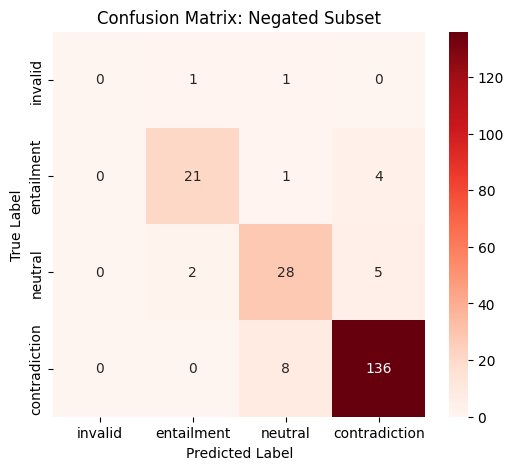

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['invalid','entailment','neutral','contradiction']

plt.figure(figsize=(6,5))
sns.heatmap(cm_negated, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Negated Subset")
plt.show()


In [93]:
misclassified = []

for i, row in enumerate(negated_subset):
    if y_true[i] != y_pred[i]:
        misclassified.append({
            "premise": row['premise'],
            "hypothesis": row['hypothesis'],
            "true_label": y_true[i],
            "pred_label": y_pred[i]
        })

print(f"Total misclassified: {len(misclassified)}\n")

# Show first 10 misclassified examples
for example in misclassified[:10]:
    print("Premise: ", example['premise'])
    print("Hypothesis: ", example['hypothesis'])
    print("True label: ", example['true_label'])
    print("Predicted label: ", example['pred_label'])
    print("-"*50)



Total misclassified: 22

Premise:  Many people standing outside of a place talking to each other in front of a building that has a sign that says "HI-POINTE."
Hypothesis:  The group of people aren't inide of the building.
True label:  0
Predicted label:  2
--------------------------------------------------
Premise:  a boy in a red hooded top is smiling whilst looking away from his reflection.
Hypothesis:  The boy doesn't want to see his reflection.
True label:  1
Predicted label:  0
--------------------------------------------------
Premise:  A very dirty race car doing a burnout on some dirt.
Hypothesis:  A car that has no tires.
True label:  2
Predicted label:  1
--------------------------------------------------
Premise:  An Ambulance is passing a man wearing a bandanna and girl.
Hypothesis:  The ambulance isn't stopped by heavy traffic
True label:  0
Predicted label:  1
--------------------------------------------------
Premise:  A fighter jet plane is landed outside Notre Dame cat